# Tutorial: Building a Browser Use Agent From Scratch and with Magentic-UI

You might have seen cool video demos online of AI agents taking control of a computer or a browser to perform tasks. This is a new category of agents referred to as Computer-Use-Agents (CUA) or Browser-Use-Agents (BUA). Examples of such CUA/BUA agents include OpenAI's Operator, Claude Computer Use Model, AutoGen's MultiModalWebSurfer, Adept AI, Google's Project Mariner and Browser-Use among many others.

Here are some example videos of such agents performing tasks
[demo 1]

[demo 2]

## What is a Computer Use Agent?

**Definition**: A computer or browser use agent is an agent that given a task, e.g., "order a shawarma sandwich from BestShawarma for pickup now", can programmatically control a computer or browser to autonomously complete the task. By "control a browser" we mean interacting with the browser in a similar way to how a human might control the browser: clicking on buttons, typing in fields, scrolling and so on. Note that a tool-use language model agent could complete this food ordering task if it had access to the restaurant API for instance, this would not make it a CUA agent as it is not _interacting_ with the browser to complete the task.

To make this distinction more clear, here is another example task.
Suppose we wanted to find the list of available Airbnbs in Miami from 6/18 to 6/20 for 2 guests.

![airbnb_sc.png](airbnb_sc.png)

How would a browser use agent solve this task:

- **Step 1:** Visit airbnb.com
- **Step 2:** Type "Miami" in the "Where" input box
- **Step 3:** Select "6/18" in the "Check in" date box
- **Step 4:** Select "6/20" in the "Check out" date box
- **Step 5:** Click on the "Who" button
- **Step 6:** Click "+" twice to add two guests
- **Step 7:** Click "Search" button
- **Step 8:** Summarize and extract listings from the webpage

On the other hand, suppose we had an API for Airbnb that looks like: `find_listings(location, check_in, check_out, guests)`

Then a tool-call agent would first need to generate a tool call: `find_listings("Miami", 6/18, 6/20, 2)` and read out the result of the tool call.

Clearly if we had an API for every website and everything on the computer, then it would be much simpler to perform this task. _But that is not the case currently_, many interfaces on the web cannot be accessed by an API and so the only way is through interacting with the website directly. While future interfaces might become more directly accessible to agents via APIs and MCP servers, for now we need to perform direct manipulation with the websites.

## What Does This Tutorial Cover?

In this tutorial, we will cover how to build a basic browser-use agent. The goal of this tutorial is to demystify such agents and show how we can build a simple version of them. The only thing we need is access to a large language model (LLM) that can perform tool calling or structured JSON outputs (GPT-4o, Qwen2.5-VL, Llama 3.1, ...). The LLM does not need to be vision capable, but a model capable of taking image input would improve performance significantly. The LLM also does not need to be trained previously for browser-use, out of the box LLMs can be turned into semi-capable browser-use agents following the recipe in this tutorial. At the end of the tutorial we will discuss further directions including training models for browser-use.

We will cover three levels of building your browser use agent:

- Level 1: From scratch using only the `playwright` python package.
- Level 2: Using helpers from the `magentic-ui` package which simplifies building your agent.
- Level 3: Using the WebSurfer Agent from the `magentic-ui` package directly.


# Tutorial Prerequisites

You will need Python >3.10 to run this tutorial and the `magentic-ui` package. [Magentic-UI](https://github.com/microsoft/magentic-ui/tree/main) is a research prototype from Microsoft of a human-centered agentic interface. In this tutorial we will be using utilities and helpers from that package without using the Magentic-UI application itself.

We recommend using a virtual environment to avoid conflicts with other packages.

```bash
python3 -m venv .venv
source .venv/bin/activate
pip install magentic-ui
```

Alternatively, if you use [`uv`](https://docs.astral.sh/uv/getting-started/installation/) for dependency management, you can install Magentic-UI with:

```bash
uv venv --python=3.12 .venv
. .venv/bin/activate
uv pip install magentic-ui
```

We also need to install the browsers that our agent will control with playwright:

```bash
playwright install --with-deps chromium
```

The other thing you need to set up is your LLM. The easiest way to follow this tutorial is to obtain an OpenAI API key and set it as an environment variable:

```bash
export OPENAI_API_KEY=<YOUR API KEY>
```

You can also use any open source model with [Ollama](https://ollama.com/) if you have a capable GPU at your disposal. We will be covering both using OpenAI and Ollama.


# Level 1: Building a Browser Use Agent From Scratch

For this level of building our browser use agent, we will only need the `playwright` and `openai` packages which are included in `magentic-ui` package.


## Step 1: Lauching a Browser

The first step is to launch the browser that our agent will control. We will be using the [Playwright](https://github.com/microsoft/playwright-python) library that provides an API to control browsers.

We can launch the browser in headless mode (we cannot see the actual browser on our machine) or non-headless where the browser will be launched locally.


In [94]:
from playwright.async_api import async_playwright

headless = False  # Change to True to run the browser in headless mode

# Launch and keep browser running
p = await async_playwright().start()
browser = await p.chromium.launch(headless=headless)
# context is the browser window
context = await browser.new_context()
# page is the tab in the browser
page = await context.new_page()
print("Browser launched!")

Browser launched!


At this point you should see a browser launched locally, it will be pointing at a blank page:

![blank_page.png](blank_page.png)


We can use the playwright API to interact with this browser, for instance let us navigate to the bing homepage (give it a few seconds)


In [95]:
await page.goto("https://www.bing.com")
print("Navigated to Bing homepage")

Navigated to Bing homepage


## Step 2: Represent the browser for the Agent using Set-Of-Marks Prompting.

Our next challenge is how do we feed the browser as input to our agent so that it is able to perform actions on it.

Using Playwright we can first take a screenshot of the browser as well as extract the text on the page.


In [ ]:
from IPython.display import Image, display

# Take a screenshot and store it in memory
screenshot_bytes = await page.screenshot()

# Display the screenshot
display(Image(screenshot_bytes))

# Get all the text on the page and print first 10 lines
text = await page.evaluate("() => document.body.innerText")
print("\nFirst 10 lines of text content:")
print("\n".join(text.split("\n")[:10]))

Now how do we get our agent to type in the search box and press search?

The key is to extract all **interactive elements** in the page using Plawright. By interactive elements we mean elements on the page we can interact with including buttons, text boxes, dropdown menus among others. Each interactive element will have an ID that we can track on the page and if it is a visible element it will have the coordinates of bounding box of the element. We will also only look at the interactive elements that are currently visibile in the current viewport, some elements might be out of view and we'd need to scroll down to view them. For simplicity, we will ignore these elements and give our agent the ability to scroll down to view them later on.


In [96]:
from dataclasses import dataclass
from playwright.async_api import Page


# A class to represent an interactive element on the page
@dataclass
class Element:
    id: int  # The id of the element
    aria_label: (
        str  # The aria-label attribute is used to provide a label for an element
    )
    type: str  # The type of the element
    bbox: dict  # The bounding box of the element
    text: str  # The text content of the element


# We will now go over the page and extract all interactive elements
# We will also add a data attribute to the element with the element ID for later reference
async def get_interactive_elements(page: Page) -> list[Element]:
    elements: list[Element] = []
    # Viewport size is a dict with keys 'width' and 'height'
    viewport_size = page.viewport_size
    print(f"Viewport size: {viewport_size}")

    # For simplicity, we will only look at buttons, textboxes, and links. We can add more roles later on.
    interactive_roles = ["button", "textbox", "link"]
    i = 0
    for role in interactive_roles:
        print(f"Getting {role} elements...")
        # We will use the Playwright API to get all elements with the given role
        elements_with_role = await page.get_by_role(role).all()
        for element in elements_with_role:
            # Check if element is visible and in current viewport
            bbox = await element.bounding_box()
            if bbox:  # Element is visible if it has a bounding box
                # Check if element is in current viewport (not scrolled out of view)
                if 0 <= bbox["y"] <= viewport_size["height"]:
                    # Set a data attribute with the element ID for later reference
                    await element.evaluate(f"el => el.setAttribute('data-element-id', '{i}')")
                    elements.append(
                        Element(
                            id=i,
                            aria_label=await element.get_attribute("aria-label")
                            or await element.get_attribute("aria-role")
                            or "",
                            type=role,
                            bbox=bbox,
                            text=await element.text_content() or "",
                        )
                    )
                    i += 1
    print(f"Found {len(elements)} visible interactive elements in current viewport:")
    return elements


elements = await get_interactive_elements(page)
formatted_list_of_elements = "\n".join(
    [f"Element {i}: {element}" for i, element in enumerate(elements)]
)
print(formatted_list_of_elements)

Viewport size: {'width': 1280, 'height': 720}
Getting button elements...
Getting textbox elements...
Getting link elements...
Found 56 visible interactive elements in current viewport:
Element 0: Element(id=0, aria_label='Microsoft Rewards', type='button', bbox={'x': 986.40625, 'y': 11.5, 'width': 119.296875, 'height': 44}, text='\n  \n  \n    \n        Rewards\n    \n  \n\n\n  \n    \n  \n      \n  \n  \n      \n  \n  \n    \n  \n\n\n    \n\n  \n\n  \n\n')
Element 1: Element(id=1, aria_label='Mobile', type='button', bbox={'x': 1117.703125, 'y': 14, 'width': 71.296875, 'height': 39}, text='Mobile')
Element 2: Element(id=2, aria_label='Settings and quick links', type='button', bbox={'x': 1205, 'y': 14, 'width': 20, 'height': 39}, text='')
Element 3: Element(id=3, aria_label='Search using voice', type='button', bbox={'x': 1047.5, 'y': 158, 'width': 17, 'height': 24}, text='')
Element 4: Element(id=4, aria_label='Search using an image', type='button', bbox={'x': 1080, 'y': 158, 'width': 2

The first question, is how do we identify the search box element on the Bing page give these elements?
We can try to read to figure this out by reading the list of elements, we can see that it is likely to be Element 19:

Element(id=19, aria_label='0 characters out of 2000', type='textbox', bbox={'x': 193, 'y': 158, 'width': 843, 'height': 22}, text='')

As this is the only texbox or searchbox element on the page.


In [102]:
# find the search box
search_box_id = None
for element in elements:
    if element.type == "textbox":
        search_box_id = element.id
        break
print(f"Search box id: {search_box_id}")

Search box id: 19


However, we also have access to the page screenshot and the coordinates of each element. A neat idea would be to superimpose the bounding boxes on top of the screenshot to better understand what each element is. This technique is called Set-of-Mark Prompting (SoM) coined by Yang, Jianwei, et al. [1] to improve visual grounding.

[1]: Yang, Jianwei, et al. "Set-of-mark prompting unleashes extraordinary visual grounding in gpt-4v." arXiv preprint arXiv:2310.11441 (2023). https://arxiv.org/pdf/2310.11441

We're gonna now implement a simplified version of SoM prompting:


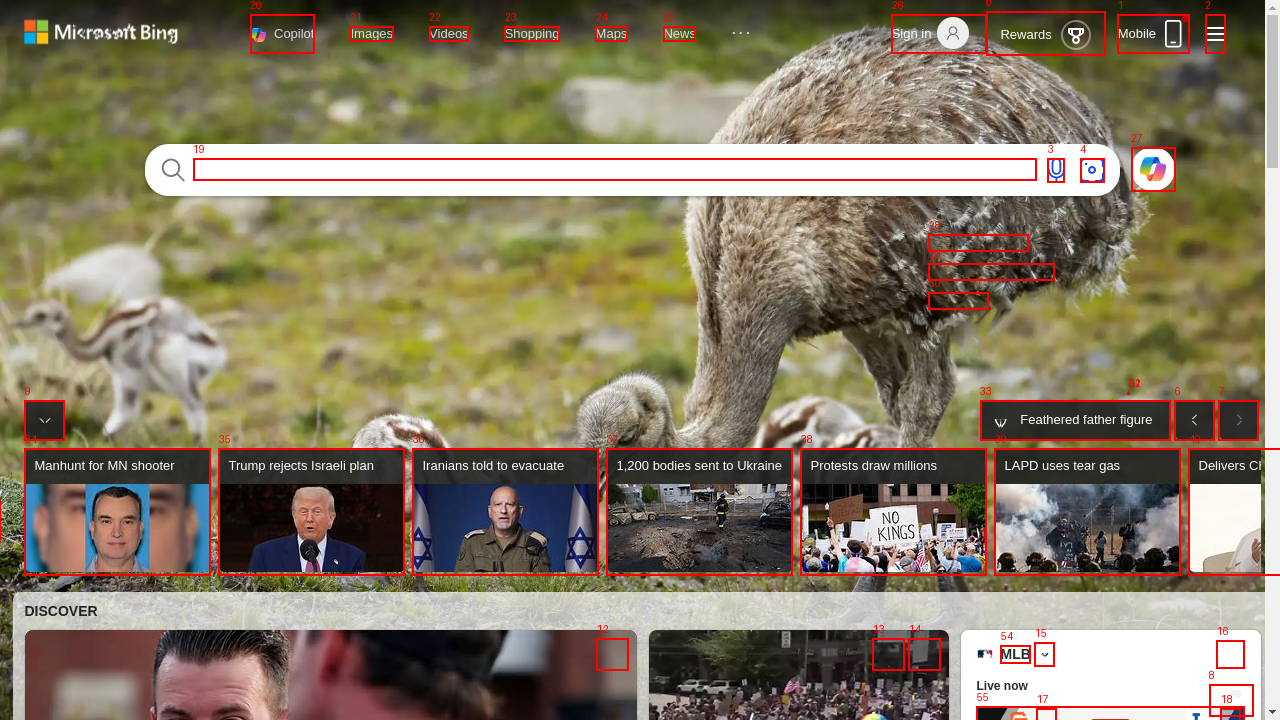

In [98]:
from PIL import Image, ImageDraw
import io


def get_som_screenshot(screenshot_bytes: bytes, elements: list[Element]) -> Image.Image:
    screenshot = Image.open(io.BytesIO(screenshot_bytes))

    # Create a drawing object
    draw = ImageDraw.Draw(screenshot)

    # Draw bounding boxes and element IDs for each element
    for element in elements:
        bbox = element.bbox
        x = bbox["x"]
        y = bbox["y"]
        width = bbox["width"]
        height = bbox["height"]

        # Draw rectangle
        draw.rectangle([(x, y), (x + width, y + height)], outline="red", width=2)

        # Draw element ID
        draw.text((x, y - 15), f"{element.id}", fill="red")

    # Display the annotated screenshot
    display(screenshot)
    som_screenshot = screenshot.copy()
    return som_screenshot


screenshot_bytes = await page.screenshot()
som_screenshot = get_som_screenshot(screenshot_bytes, elements)

This confirms what we previously found that Element with id=19 is in fact the searchbox!

Let us now wrap what we just did in a helper function to prepare the page to be used as input to our agent:


In [99]:
async def prepare_page_for_agent(page: Page) -> tuple[str, str, Image.Image]:
    """
    Prepare the page for the agent.
    Returns:
        tuple[str, str, Image.Image]: The page text, the formatted list of elements, and the screenshot with bounding boxes.
    """
    page_text = await page.evaluate("() => document.body.innerText")
    elements = await get_interactive_elements(page)
    screenshot_bytes = await page.screenshot()
    som_screenshot = get_som_screenshot(screenshot_bytes, elements)

    formatted_list_of_elements = "\n".join(
        [f"Element {i}: {element}" for i, element in enumerate(elements)]
    )

    return page_text, formatted_list_of_elements, som_screenshot


# page_text, formatted_list_of_elements, screenshot = await prepare_page_for_agent(page)

## Step 3: Define Agent Action Space

Now that we have established how to represent the browser state for our Agent, it's time to define our Agent architecture. This section will cover the action space and execution flow that enables our agent to perform tasks using the browser.

### Action Space Definition

Our web agent operates with a carefully designed set of actions that cover the fundamental browser interactions needed for most web automation tasks:

- **`goto(url)`**: Navigate to a specific URL
- **`click(id)`**: Click on an element identified by its ID
- **`type(id, text)`**: Input text into a form field or text element by ID
- **`scroll(direction)`**: Scroll the page vertically (up/down)
- **`stop_action(final_answer)`**: Complete the task and return the final result

_Note: This is a simplfied action set designed for our initial prototype. It can be extended with additional actions like hover, select, wait, etc., as needed._

### Agent Architecture Flow

The following diagram illustrates how our web agent processes user queries and executes actions:

```mermaid
flowchart TD
    A["Input: User Query"] --> B["Initialize Agent"]
    B --> C["Capture Current Page State"]
    C --> D["Analyze Page & Query"]
    D --> E{Action Decision}
    E -->|goto| F["Navigate to URL"]
    E -->|click| G["Click Element by ID"]
    E -->|type| H["Type Text in Element"]
    E -->|scroll| I["Scroll Page"]
    E -->|stop_action| J["Return Final Answer"]
    F --> K["Execute Action"]
    G --> K
    H --> K
    I --> K
    K --> C
    J --> L["Output: Final Answer"]

    style A fill:#e1f5fe
    style L fill:#e8f5e8
    style E fill:#fff3e0
    style J fill:#ffebee
```

### Execution Flow Details

1. **Input Processing**: The agent receives a user query describing the desired task
2. **State Capture**: Current browser page state is captured and processed
3. **Action Selection**: Based on the analysis, one of the five actions is chosen
4. **Execution**: The selected action is executed in the browser. We append the feedback of the action into the chat history.
5. **Loop Continuation**: The process repeats until `stop_action` is triggered

The agent continues this loop until it determines the task is complete, at which point it executes `stop_action` with the final answer.


Our first step is to create the prompt template for the model to decide on the correct action. Instead of using tool calling to decide on the action, we will JSON outputs for simplicity.


In [100]:
AGENT_PROMPT = """
You are a helpful assistant that can navigate a web page and perform actions on it.

The task we are trying to complete is:
{task}

The current visible text on the page is:
{page_text}

The current visible elements on the page are:
{formatted_list_of_elements}

You will need to decide on the next action to take.

The action space is:
- goto(url): navigate to a URL
- click(id): click a button given it's ID
- type(id, text): type "text" into element "id"
- scroll(direction): scroll the page in direction up or down.
- stop_action(final_answer): declare that we have finished the task and prepare a final_answer to return to the user.

Output a JSON object with the following fields:
{{
    "action": "goto" | "click" | "type" | "scroll" | "stop_action",
    "action_args": {{
        "url": "https://www.google.com",
        "id": "123",
        "text": "Hello",
        "direction": "up"
    }}
}}

Only output the JSON object, no other text or comments.
"""

Let's now try this prompt with our LLM:


Viewport size: {'width': 1280, 'height': 720}
Getting button elements...
Getting textbox elements...
Getting link elements...
Found 57 visible interactive elements in current viewport:


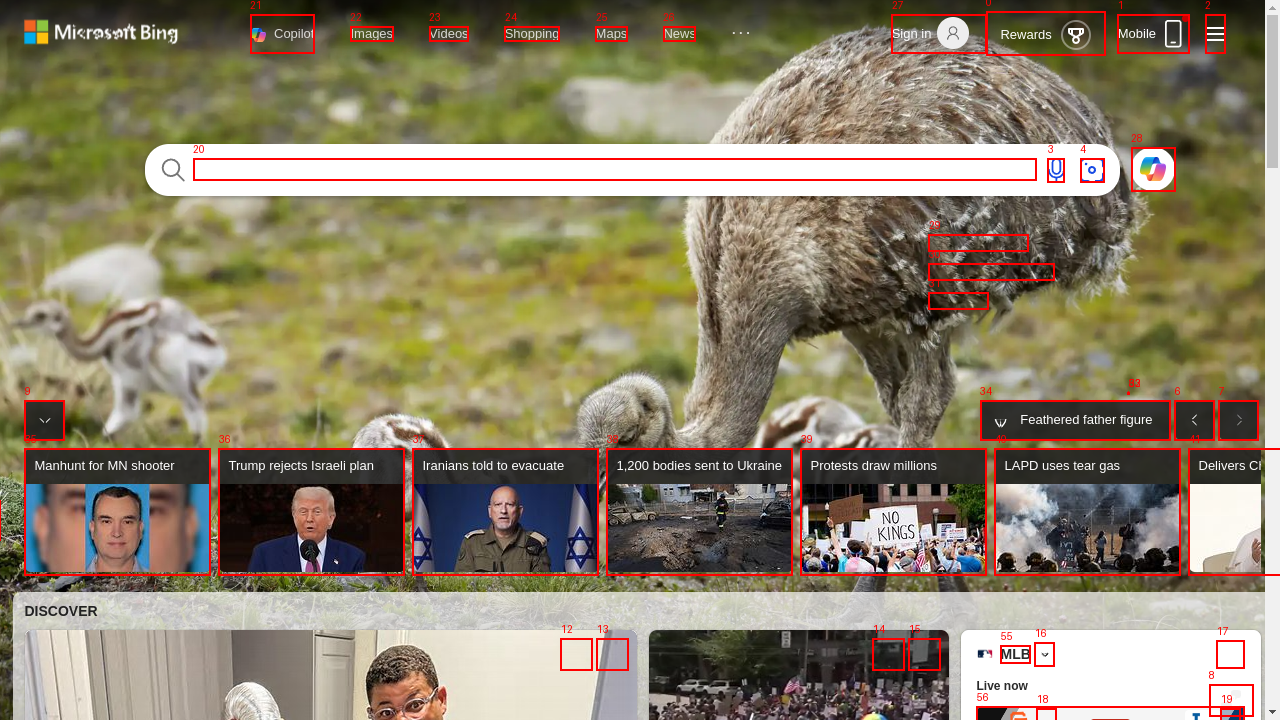

Model's decision: {
  "action": "type",
  "action_args": {
    "id": "20",
    "text": "Magentic-UI"
  }
}
{'action': 'type', 'action_args': {'id': '20', 'text': 'Magentic-UI'}}


In [101]:
from openai import OpenAI
import json
import base64
from PIL import Image
import os

# Prepare the page for the agent
page_text, formatted_list_of_elements, som_screenshot = await prepare_page_for_agent(
    page
)
task = "Search for Magentic-UI"
# Now make the API call
client = OpenAI(
    api_key=os.getenv("OPENAI_API_KEY")
)  # you can use any other LLM client here
image_data_url = f"data:image/png;base64,{base64.b64encode((lambda b: (som_screenshot.save(b, format='PNG'), b.getvalue())[1])(io.BytesIO())).decode()}"


def get_llm_response(
    client: OpenAI,  # OpenAI client
    task: str,  # Task to complete
    page_text: str,  # Page text
    formatted_list_of_elements: str,  # Formatted list of elements
    image_data_url: str,  # Image data URL
    message_history: list[dict] = [],  # Message history
    model: str = "gpt-4o",  # Model to use
) -> dict:
    response = client.chat.completions.create(
        model=model,
        messages=[
            *message_history,
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": AGENT_PROMPT.format(
                            task=task,
                            page_text=page_text,
                            formatted_list_of_elements=formatted_list_of_elements,
                        ),
                    },
                    {
                        "type": "image_url",
                        "image_url": {"url": image_data_url},
                    },
                ],
            },
        ],
    )

    # Parse the response
    try:
        action_decision = json.loads(response.choices[0].message.content)
        print("Model's decision:", json.dumps(action_decision, indent=2))
    except json.JSONDecodeError:
        # it starts with ```json
        response_content = response.choices[0].message.content
        response_content = response_content.replace("```json", "").replace("```", "")
        action_decision = json.loads(response_content)
        print("Model's decision:", json.dumps(action_decision, indent=2))
    except Exception as e:
        raise e
    return action_decision


action_decision = get_llm_response(
    client, task, page_text, formatted_list_of_elements, image_data_url
)
print(action_decision)

We can see that the model made the right decision given the task of "Search for Magentic-UI", the action is to type in the search box for "Magentic-UI"

The last remaining piece before we put it all together is to now execute the action using Playwright.

## Step 4: Executing the actions with Playwright

For each of the actions we have previously defined, we will now write code using Playwright to execute them.

In [103]:
# This is mostly basic Playwright code, but we will use it to execute the actions.
async def execute_action(action: str, action_args: dict, page: Page) -> str:
    """
    Execute an action on the page.
    """
    if action == "goto":
        await page.goto(action_args["url"])
        return f"I navigated to {action_args['url']}"
    elif action == "click":
        # Get the element using the data attribute
        await page.wait_for_selector(f"[data-element-id='{action_args['id']}']")
        element = page.locator(f"[data-element-id='{action_args['id']}']")
        if element:
            await element.click()
        else:
            raise ValueError(f"Element with ID {action_args['id']} not found")
        return f"I clicked on {action_args['id']}"
    elif action == "type":
        await page.wait_for_selector(f"[data-element-id='{action_args['id']}']")
        element = page.locator(f"[data-element-id='{action_args['id']}']")
        if element:
            await element.fill(action_args["text"])
        else:
            raise ValueError(f"Element with ID {action_args['id']} not found")
        return f"I typed {action_args['text']} into {action_args['id']}"
    elif action == "scroll":
        await page.scroll(action_args["direction"])
        return f"I scrolled {action_args['direction']}"
    elif action == "stop_action":
        return action_args["final_answer"]
    else:
        raise ValueError(f"Invalid action: {action}")

In [105]:
await execute_action(action_decision["action"], action_decision["action_args"], page)

'I typed Magentic-UI into 20'

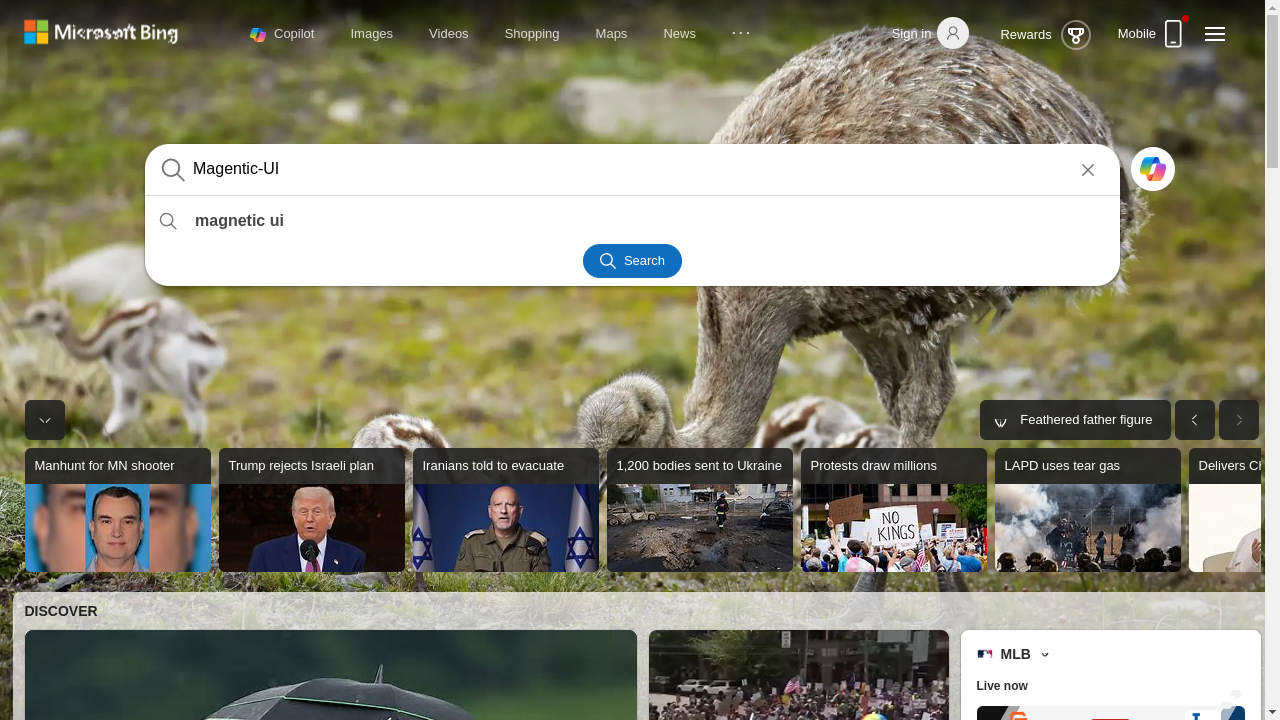

In [106]:
# Take a screenshot of the page
screenshot = await page.screenshot()
display(Image.open(io.BytesIO(screenshot)))

Success! We can see that our agent was properly able to type "Magentic-UI" into the searchbox!

The final step is to put it all together into our Agent!

## Step 5: Putting it all together into our Agent

In [121]:
from openai import OpenAI
from playwright.async_api import Page
from playwright.async_api import async_playwright
from PIL import Image, ImageDraw
import io
import base64
import json
from dataclasses import dataclass


class BrowserUseAgent:
    def __init__(self, client: OpenAI, model: str = "gpt-4o", headless: bool = False):
        self.client = client
        self.model = model
        self.headless = headless
        self.message_history: list[dict] = []
        self.page: Page = None

    async def launch_browser(self) -> None:
        p = await async_playwright().start()
        self.browser = await p.chromium.launch(headless=self.headless)
        # context is the browser window
        self.context = await self.browser.new_context()
        # page is the tab in the browser
        self.page = await self.context.new_page()

    async def execute_task(self, task: str) -> str:
        # We need to launch the browser if it's not already launched
        if self.page is None:
            await self.launch_browser()
        # Our stop condition is when the LLM decides to output stop_action
        should_stop = False
        final_answer = None
        i = 0
        while not should_stop:
            # Step 1: Prepare the page for the agent
            (
                page_text,
                formatted_list_of_elements,
                som_screenshot,
            ) = await self.prepare_page_for_agent(self.page)
            # Step 2: Get the LLM response
            image_data_url = f"data:image/png;base64,{base64.b64encode((lambda b: (som_screenshot.save(b, format='PNG'), b.getvalue())[1])(io.BytesIO())).decode()}"
            action_decision = await self.get_llm_response(
                self.client,
                task,
                page_text,
                formatted_list_of_elements,
                image_data_url,
                self.message_history,
            )
            print(f"Action decision {i}: {action_decision}")
            # Add the action decision to the message history
            self.message_history.append(
                {
                    "role": "user",
                    "content": [{"type": "text", "text": json.dumps(action_decision)}],
                }
            )
            # Step 3: Execute the action
            action_feedback = await self.execute_action(
                action_decision["action"], action_decision["action_args"], self.page
            )
            print(f"Action feedback {i}: {action_feedback}")
            # Update the message history with feedback on the action and the new page screenshot
            new_page_screenshot = await self.page.screenshot()
            self.message_history.append(
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": action_feedback},
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/png;base64,{base64.b64encode(new_page_screenshot).decode()}"
                            },
                        },
                    ],
                }
            )
            # Step 4: Check if the task is complete
            should_stop = action_decision["action"] == "stop_action"
            if should_stop:
                final_answer = action_decision["action_args"]["final_answer"]
        return final_answer

    async def execute_action(self, action: str, action_args: dict, page: Page) -> str:
        """
        Execute an action on the page.
        """
        if action == "goto":
            await page.goto(action_args["url"])
            return f"I navigated to {action_args['url']}"
        elif action == "click":
            # Get the element using the data attribute
            await page.wait_for_selector(f"[data-element-id='{action_args['id']}']")
            element = page.locator(f"[data-element-id='{action_args['id']}']")
            if element:
                await element.click()
            else:
                raise ValueError(f"Element with ID {action_args['id']} not found")
            return f"I clicked on {action_args['id']}"
        elif action == "type":
            await page.wait_for_selector(f"[data-element-id='{action_args['id']}']")
            element = page.locator(f"[data-element-id='{action_args['id']}']")
            if element:
                await element.fill(action_args["text"])
            else:
                raise ValueError(f"Element with ID {action_args['id']} not found")
            return f"I typed {action_args['text']} into {action_args['id']}"
        elif action == "scroll":
            await page.scroll(action_args["direction"])
            return f"I scrolled {action_args['direction']}"
        elif action == "stop_action":
            return action_args["final_answer"]
        else:
            raise ValueError(f"Invalid action: {action}")


    def get_llm_response(
        self,
        client: OpenAI,  # OpenAI client
        task: str,  # Task to complete
        page_text: str,  # Page text
        formatted_list_of_elements: str,  # Formatted list of elements
        image_data_url: str,  # Image data URL
        message_history: list[dict] = [],  # Message history
        model: str = "gpt-4o",  # Model to use
    ) -> dict:
        response = client.chat.completions.create(
            model=model,
            messages=[
                *message_history,
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": AGENT_PROMPT.format(
                                task=task,
                                page_text=page_text,
                                formatted_list_of_elements=formatted_list_of_elements,
                            ),
                        },
                        {
                            "type": "image_url",
                            "image_url": {"url": image_data_url},
                        },
                    ],
                },
            ],
        )

        # Parse the response
        try:
            action_decision = json.loads(response.choices[0].message.content)
        except json.JSONDecodeError:
            # it starts with ```json
            response_content = response.choices[0].message.content
            response_content = response_content.replace("```json", "").replace("```", "")
            action_decision = json.loads(response_content)
        except Exception as e:
            raise e
        return action_decision


    async def prepare_page_for_agent(self, page: Page) -> tuple[str, str, Image.Image]:
        """
        Prepare the page for the agent.
        Returns:
            tuple[str, str, Image.Image]: The page text, the formatted list of elements, and the screenshot with bounding boxes.
        """
        page_text = await page.evaluate("() => document.body.innerText")
        elements = await self.get_interactive_elements(page)
        screenshot_bytes = await page.screenshot()
        som_screenshot = self.get_som_screenshot(screenshot_bytes, elements)

        formatted_list_of_elements = "\n".join(
            [f"Element {i}: {element}" for i, element in enumerate(elements)]
        )

        return page_text, formatted_list_of_elements, som_screenshot


    def get_som_screenshot(
        self, screenshot_bytes: bytes, elements: list[Element]
    ) -> Image.Image:
        screenshot = Image.open(io.BytesIO(screenshot_bytes))

        # Create a drawing object
        draw = ImageDraw.Draw(screenshot)

        # Draw bounding boxes and element IDs for each element
        for element in elements:
            bbox = element.bbox
            x = bbox["x"]
            y = bbox["y"]
            width = bbox["width"]
            height = bbox["height"]

            # Draw rectangle
            draw.rectangle([(x, y), (x + width, y + height)], outline="red", width=2)

            # Draw element ID
            draw.text((x, y - 15), f"{element.id}", fill="red")

        som_screenshot = screenshot.copy()
        return som_screenshot



    async def get_interactive_elements(self, page: Page) -> list[Element]:
        elements: list[Element] = []
        # Viewport size is a dict with keys 'width' and 'height'
        viewport_size = page.viewport_size

        # For simplicity, we will only look at buttons, textboxes, and links. We can add more roles later on.
        interactive_roles = ["button", "textbox", "link"]
        i = 0
        for role in interactive_roles:
            # We will use the Playwright API to get all elements with the given role
            elements_with_role = await page.get_by_role(role).all()
            for element in elements_with_role:
                # Check if element is visible and in current viewport
                bbox = await element.bounding_box()
                if bbox:  # Element is visible if it has a bounding box
                    # Check if element is in current viewport (not scrolled out of view)
                    if 0 <= bbox["y"] <= viewport_size["height"]:
                        # Set a data attribute with the element ID for later reference
                        await element.evaluate(
                            f"el => el.setAttribute('data-element-id', '{i}')"
                        )
                        elements.append(
                            Element(
                                id=i,
                                aria_label=await element.get_attribute("aria-label")
                                or await element.get_attribute("aria-role")
                                or "",
                                type=role,
                                bbox=bbox,
                                text=await element.text_content() or "",
                            )
                        )
                        i += 1
        return elements

        
    async def close(self) -> None:
        if self.page is not None:
            await self.page.close()
        if self.context is not None:
            await self.context.close()
        if self.browser is not None:
            await self.browser.close()



In [122]:
from openai import OpenAI
import os
openai_client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
agent = BrowserUseAgent(openai_client)
try:
    final_answer = await agent.execute_task("Search for Magentic-UI")
    print(final_answer)
finally:
    await agent.close()

TypeError: Object of type Image is not JSON serializable

# Level 2: Building a Browser Use Agent Using Magentic-UI


# Level 3: Using the WebSurfer Agent from Magentic-UI


# Magentic-UI


# What's next?

- Limitations

drag or paint

video

- Evaluation

- Training your web agent model

- Safety
